## Data Preparation 

We use Beeline benchmark to benchmark the performance of DeepSEM.
The data preparation process are shown in below.
1. Download raw data from https://doi.org/10.5281/zenodo.3378975, which is provided by BEELINE benchmark
2. Use the preoprocess code in https://github.com/Murali-group/Beeline/blob/master/generateExpInputs.py to generate dataset.

We also provide demo data as shown in ../demo_data/GRN_inference/input 

# Run DeepSEM by using following command:
for cell type specific GRN inference task: python main.py --task non_celltype_GRN --data_file demo_data/GRN_inference/input/500_STRING_hESC/data.csv --net_file demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --alpha 100 --beta 1 --n_epoch 90 --save_name out


for cell type non-specific GRN inference task: python main.py --task celltype_GRN --data_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

**Parameters**

- $\alpha$ is the $\mathcal{L}^1$ regularization factor
- $\beta$ is the coefficient of the $KL$ divergence loss


In [39]:
import pandas as pd 
input = pd.read_csv("../demo_data/GRN_inference/input/500_STRING_hESC/data.csv", index_col = 0)
keepcols = list(input.var(0) > 10.82) #threshold to keep 100 most variable genes
input = input[input.columns[keepcols]]
input.to_csv("../demo_data/GRN_inference/input/500_STRING_hESC/data2.csv")

In [55]:
label = pd.read_csv("../demo_data/GRN_inference/input/500_STRING_hESC/label.csv")
count = 0
gene_feats = set(input.columns)
label.apply(lambda x: x if (x in gene_feats and x in gene_feats))

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [40]:
!python ../main.py --task non_celltype_GRN --data_file ../demo_data/GRN_inference/input/500_STRING_hESC/data2.csv --net_file ../demo_data/GRN_inference/input/500_STRING_hESC/label.csv --setting new --inverse 1 --alpha 100 --beta 1 --n_epoch 90 --save_name out
#!python ../main.py --task celltype_GRN --data_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/data.csv --net_file ../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 150  --save_name out

Using inverse constraint
dir exist
Traceback (most recent call last):
  File "../main.py", line 55, in <module>
    model.train_model()
  File "/home/jel-khoury/DeepSEM/src/DeepSEM_cell_type_non_specific_GRN_model.py", line 221, in train_model
    Ep, Epr = evaluate(vae.adj_A.cpu().detach().numpy(), truth_edges, Evaluate_Mask)
  File "/home/jel-khoury/DeepSEM/src/utils.py", line 33, in evaluate
    cutoff_all = A_val[num_truth_edges]
IndexError: list index out of range


# Calculate EPR values

In [7]:
import pandas as pd
#col1 = "Gene1"
#col2 = "Gene2"
col1 = "TF"
col2 = "Target"
output = pd.read_csv("out/GRN_inference_result.tsv",sep='\t')
output['EdgeWeight'] = abs(output['EdgeWeight'])
output = output.sort_values('EdgeWeight',ascending=False)
label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label.csv')
#label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
output = output[output[col1].apply(lambda x: x in TFs)]
output = output[output[col2].apply(lambda x: x in Genes)]
label_set = set(label['Gene1']+'|'+label['Gene2'])
output = output.iloc[:len(label_set)]
len(set(output[col1]+'|'+output[col2]) & label_set) / (len(label_set)**2/(len(TFs)*len(Genes)-len(TFs)))


3.769847879784455

# Calculate AUPR ratio values

In [21]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
import pandas as pd
output = pd.read_csv("out/GRN_inference_result.tsv",sep='\t')
output['EdgeWeight'] = abs(output['EdgeWeight'])
output = output.sort_values('EdgeWeight',ascending=False)
label = pd.read_csv('../demo_data/GRN_inference/input/500_STRING_hESC/label.csv')
#label = pd.read_csv("../demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv")
TFs = set(label['Gene1'])
Genes = set(label['Gene1'])| set(label['Gene2'])
print("number or target genes in output :", len(output['Target'].unique()))
print("number or TFs in output :", len(output['TF'].unique()))

output = output[output[col1].apply(lambda x: x in TFs)]
output = output[output[col2].apply(lambda x: x in Genes)]
label_set = set(label['Gene1']+'|'+label['Gene2'])
preds,labels,randoms = [] ,[],[]
res_d = {}
l = []
p= []
for item in (output.to_dict('records')):
        res_d[item[col1] + '|' + item[col2]] = item['EdgeWeight']
for item in (set(label['Gene1'])):
        for item2 in  set(label['Gene1'])| set(label['Gene2']):
            if item+ '|' + item2 in label_set:
                l.append(1)
            else:
                l.append(0)
            if item + '|' + item2 in res_d:
                p.append(res_d[item + '|' + item2])
            else:
                p.append(-1)
                
print("AUPRC = ", average_precision_score(l,p))
print(average_precision_score(l,p)/np.mean(l))
precision, recall, thresholds = precision_recall_curve(l, p)

number or target genes in output : 910
number or TFs in output : 343
AUPRC =  0.04627830024881518
1.927784181682557


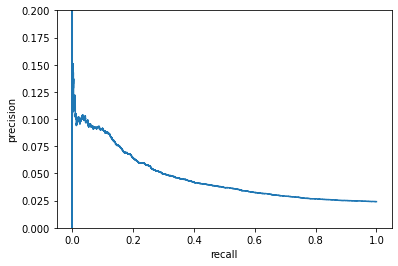

In [11]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.ylim(0, 0.2)
plt.show()

# Ensemble DeepSEM result

In [52]:
res = []
for i in range(10):
    res.append(pd.read_csv('../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv',sep='\t'))
res = pd.concat(res)
res['EdgeWeight'] = abs(res['EdgeWeight'])
res.groupby(['Gene1','Gene2']).mean()

FileNotFoundError: [Errno 2] File ../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv does not exist: '../../scGRN/Upload/GRN_inference_benchmark/cross_validation/500_STRING_hESC/rep_i.csv'